In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
os.environ["KERAS_BACKEND"] = "tensorflow" 
import tensorflow
import keras
from tensorflow.keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from tensorflow.keras.models import Model, Sequential
from keras.objectives import binary_crossentropy
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K
import random
import scipy
from scipy.stats import norm
from scipy.stats import multivariate_normal
import sklearn
from sklearn import model_selection
from tensorflow.keras.optimizers import SGD, Adam, Adamax

Using TensorFlow backend.


In [ ]:
%pip install --user keras==2.2.5

In [4]:
#read data
X = pd.read_csv("Aug22.csv")
print(X.head())
outcome_vars = X.columns[10:]
outcome_vars

   Unnamed: 0  jet_1_pt   jet_2_pt   jet_1_e   jet_2_e   delta_phi  \
0         489  1.064990   0.354724  1.195620  0.617188    0.890958   
1          58  0.713328   0.406958  0.628125  0.608437    1.116200   
2         119  0.604246   0.460719  0.721875  0.459062    0.979828   
3         466  6.577490   5.563100  5.565000  4.565000    0.968476   
4          19  0.535902   0.429245  0.499375  0.394062    0.724647   

    delta_eta   centrality   multiplicity_1   multiplicity_2  \
0    0.664917        0.525             0.27             0.34   
1   -0.188610        1.990             0.23             0.17   
2    0.026245        1.990             0.11             0.17   
3   -0.161133        0.475             0.42             0.28   
4    0.166023        1.990             0.08             0.09   

    collision_system  
0                  1  
1                  0  
2                  0  
3                  1  
4                  0  


Index([' collision_system'], dtype='object')

In [3]:
X = pd.read_csv('newvariables.csv')
ds = X.sample(frac=1)
ds.to_csv('Aug22.csv')

In [5]:
X.drop(X.columns[[0]], axis = 1, inplace = True) 

Y_train= X[outcome_vars]
X_train = X.drop(list(outcome_vars), axis=1)
print(X_train.head())
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_train.shape
#Y_train.shape


   jet_1_pt   jet_2_pt   jet_1_e   jet_2_e   delta_phi   delta_eta  \
0  1.064990   0.354724  1.195620  0.617188    0.890958    0.664917   
1  0.713328   0.406958  0.628125  0.608437    1.116200   -0.188610   
2  0.604246   0.460719  0.721875  0.459062    0.979828    0.026245   
3  6.577490   5.563100  5.565000  4.565000    0.968476   -0.161133   
4  0.535902   0.429245  0.499375  0.394062    0.724647    0.166023   

    centrality   multiplicity_1   multiplicity_2  
0        0.525             0.27             0.34  
1        1.990             0.23             0.17  
2        1.990             0.11             0.17  
3        0.475             0.42             0.28  
4        1.990             0.08             0.09  


(497, 9)

In [6]:
def evaluate_vae_model(X_train, latent_dimensions, intermediate_dimensions):
    
    
    intermediate_dim = intermediate_dimensions
    latent_dim = latent_dimensions
    
   
    original_dim = X_train.shape[1]
    batch_size = 16
    n_epochs = 100
    
    # The Encoder, from the original data to the latent dimensions
    inputs = Input(shape=(original_dim,))
    
    hidden = Dense(intermediate_dim, activation='relu')(inputs)
    hidden2 = Dense(intermediate_dim, activation='sigmoid')(hidden)
    z_mean = Dense(latent_dim, activation='linear')(hidden2)
    z_sigma = Dense(latent_dim,activation='linear')(hidden2)
    
    # The sampler
    def sample_z(args):
        z_mean, z_sigma = args
        eps = K.random_normal(shape=(K.shape(inputs)[0],latent_dim), mean=0., stddev=1.)
        return z_mean + K.exp(z_sigma / 2) * eps 

    z = Lambda(sample_z, output_shape=(latent_dim,))([z_mean, z_sigma])
    encoder = Model(inputs, z_mean)
    
    # The Decoder
    decoder_hidden = Dense(intermediate_dim, activation='relu') 
    decoder_mean = Dense(original_dim, activation='linear')  
    decoder_sigma = Dense(original_dim, activation='linear')


    hidden_output = decoder_hidden(z)
    output_decoded_mean = decoder_mean(hidden_output) 
    output_decoded_sigma = decoder_sigma(hidden_output) 

    decoder = Model(inputs, output_decoded_mean)
    
    
    
    predictor_input = Input(shape=(latent_dim,))

    predictor_decoded = decoder_hidden(predictor_input)
    predictor_output_mean = decoder_mean(predictor_decoded)
    predictor_output_sigma = decoder_sigma(predictor_decoded)

    predictor = Model(predictor_input, predictor_output_mean)
    
    
    def vae_loss(y_true, y_pred):
        reconstruction_loss = neg_log_likelihood(y_true, y_pred)
        kl_loss = KL_divergence_loss(y_true, y_pred)
        return reconstruction_loss + kl_loss

    def neg_log_likelihood(y_true, y_pred):
        negative_log_likelihood = (1./2.) * \
                        (
                            K.int_shape(inputs)[1] * K.log(2. * np.pi) + \
                            K.sum(output_decoded_sigma, axis=-1, keepdims=True) + \
                            K.sum(
                                K.square(y_true - y_pred) * (1. / K.exp(output_decoded_sigma)), 
                                axis=-1, keepdims=True
                            )
                        )
        return negative_log_likelihood

    
    def KL_divergence_loss(y_true, y_pred):
        """ Calculate the KL Divergence portion of the loss, i.e. D_KL(Q(z|X) || P(z|X)) """
        return 0.5 * K.sum(K.exp(z_sigma) + K.square(z_mean) - 1. - z_sigma, axis=-1)
    
    
    
    def squared_difference_loss(y_true, y_pred):
        """ Calculate a naive reconstruction loss, i.e. ||y_true - y_pred||^2 """
        return K.sum(K.square(y_true - y_pred), axis=-1)

    decoder.compile(optimizer=Adam(lr=0.0001), 
                loss=vae_loss, 
                metrics=[ squared_difference_loss,
                         KL_divergence_loss, 
                         neg_log_likelihood, 
                        ] 
            
               )

    #early stopping callback criterion so that we don't overfit
    earlystop = keras.callbacks.EarlyStopping(monitor='val_loss',  
                                             min_delta=0.0001,  
                                             patience=10, 
                                             verbose=0,
                                             mode='min') 
    
    #checkpointer = keras.callbacks.ModelCheckpoint(filepath="weights_filter_test.hdf5", verbose=1, save_best_only=False)
    
    callbacks_list = [earlystop]
    
    history = decoder.fit(X_train,
                      X_train,
                      shuffle=True,
                      epochs=n_epochs,
                      verbose=1,
                      batch_size=batch_size,
                      callbacks=callbacks_list,
                      #validation_split=0.3
                      )
    
    
    
    decoder.save_weights("decoder_relu_deep6.h5")
    encoder.save_weights("encoder_relu_deep6.h5")
    predictor.save_weights("predictor_relu_deep6.h5")
    
    return encoder, predictor, decoder, history
    

In [7]:
n_z = 2
n_h = 6
encoder, predictor, decoder, history = evaluate_vae_model(X_train, n_z, n_h)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 497 samples
Epoch 1/100
497/497 [==============================] - 1s 1ms/sample - loss: 13.6270 - squared_difference_loss: 7.4746 - KL_divergence_loss: 0.4584 - neg_log_likelihood: 13.1686
Epoch 2/100
497/497 [==============================] - 0s 124us/sample - loss: 13.3901 - squared_difference_loss: 7.2880 - KL_divergence_loss: 0.4439 - neg_log_likelihood: 12.9462
Epoch 3/100
497/497 [==============================] - 0s 98us/sample - loss: 13.5715 - squared_difference_loss: 7.3127 - KL_divergence_loss: 0.4314 - neg_log_likelihood: 13.1401
Epoch 4/100
497/497 [==============================] - 0s 97us/sample - loss: 12.8713 - squared_difference_loss: 6.8741 - KL_divergence_loss: 0.4196 - neg_log_likelihood: 12.4518
Epoch 5/100
 16/497 [..............................] - ETA: 0s - loss: 12.1097 - squared_difference_loss: 5.6490 - KL_divergence_loss: 0.4149 - neg_log_likelihood: 11.6948

/global/homes/s/stuti/.local/cori/intel-tensorflow1.15.0-py37/lib/python3.7/site-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,squared_difference_loss,KL_divergence_loss,neg_log_likelihood
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


497/497 [==============================] - 0s 102us/sample - loss: 13.0230 - squared_difference_loss: 6.9085 - KL_divergence_loss: 0.4089 - neg_log_likelihood: 12.6141
Epoch 6/100
497/497 [==============================] - 0s 101us/sample - loss: 12.6060 - squared_difference_loss: 6.6006 - KL_divergence_loss: 0.3990 - neg_log_likelihood: 12.2069
Epoch 7/100
497/497 [==============================] - 0s 101us/sample - loss: 12.2327 - squared_difference_loss: 6.3151 - KL_divergence_loss: 0.3902 - neg_log_likelihood: 11.8425
Epoch 8/100
497/497 [==============================] - 0s 100us/sample - loss: 12.1689 - squared_difference_loss: 6.2190 - KL_divergence_loss: 0.3823 - neg_log_likelihood: 11.7866
Epoch 9/100
497/497 [==============================] - 0s 100us/sample - loss: 12.1551 - squared_difference_loss: 6.1928 - KL_divergence_loss: 0.3738 - neg_log_likelihood: 11.7813
Epoch 10/100
497/497 [==============================] - 0s 101us/sample - loss: 11.9805 - squared_difference_los

In [20]:
Y_test.columns.values

NameError: name 'Y_test' is not defined

In [54]:
#read data
Xt = pd.read_csv("Aug17-Copy1.csv")
outcome_vars = Xt.columns[9:]
outcome_vars

Index([' collision_system'], dtype='object')

In [55]:
Xt.drop(Xt.columns[[0]], axis = 1, inplace = True) 

Yt_train= Xt[outcome_vars]
Xt_train = Xt.drop(list(outcome_vars), axis=1)
print(Xt_train.head)
Xt_train = np.array(Xt_train)
Yt_train = np.array(Yt_train)
Xt_train.shape
#Y_train.shape

<bound method NDFrame.head of      jet_1_pt   jet_2_pt       A_j   delta_phi   delta_eta   centrality  \
0    6.577490   5.563100  0.083554   -0.098984   -0.161133       0.4750   
1    0.751327   0.373431  0.335980   -0.118310   -0.247925       1.9900   
2    0.436217   0.349843  0.109882    0.238906    0.603027       1.9900   
3    0.601918   0.353475  0.260043   -0.152390    0.333618       0.5750   
4    1.372460   0.482996  0.479377   -0.126496   -0.123291       0.5950   
..        ...        ...       ...         ...         ...          ...   
474  0.503233   0.287203  0.273304   -0.333848   -0.512817       0.0345   
475  1.132040   0.823685  0.157667    0.051467   -0.581299       0.2950   
476  0.350724   0.319117  0.047186   -0.536240    0.123169       0.3250   
477  0.627423   0.312654  0.334833    0.462539    0.038818       0.0425   
478  0.564384   0.371088  0.206629    0.079238   -0.599609       0.0475   

       frag_1    frag_2  
0   -0.017790 -0.105311  
1   -2.170210 -1.

(479, 8)

In [17]:
encoder.load_weights("encoder.h5")

In [30]:
import matplotlib
import matplotlib.pyplot as plt
Yt_train_color=[]

for i in range(len(Yt_train)):
    if Yt_train[i]==1:
        Yt_train_color.append("red")
    elif Yt_train[i]==0:
        Yt_train_color.append("blue")
    else:
        Yt_train_color.append("green")
#print(Y_train_color)
z_mean = encoder.predict(Xt_train)
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1] , c=Yt_train_color)

plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()



NameError: name 'Yt_train' is not defined

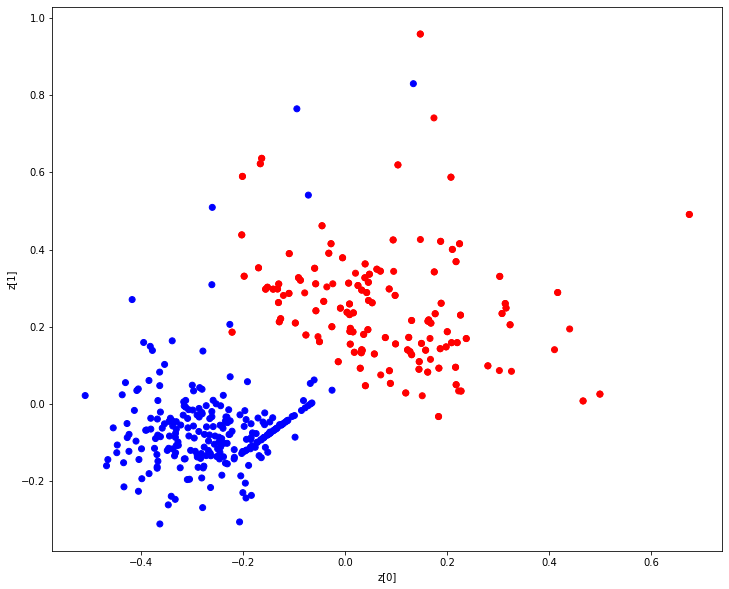

In [43]:
import matplotlib
import matplotlib.pyplot as plt
Y_train_color=[]

for i in range(len(Y_train)):
    if Y_train[i]==1:
        Y_train_color.append("red")
    else:
        Y_train_color.append("blue")
#print(Y_train_color)
z_mean = encoder.predict(X_train)
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1] , c=Y_train_color)

plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
Y_train_color=[]
#print(len(Y_train_color))
#print(Y_train_color[0])
for i in range(len(Y_train)):
    if Y_train[i]==1:
        Y_train_color.append("red")
    else:
        Y_train_color.append("blue")
#print(Y_train_color)
z_mean = encoder.predict(X_train)
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 1], z_mean[:, 2] , c=Y_train_color)

plt.xlabel("z[1]")
plt.ylabel("z[2]")
plt.show()


AttributeError: module 'matplotlib.pyplot' has no attribute 'zlabel'

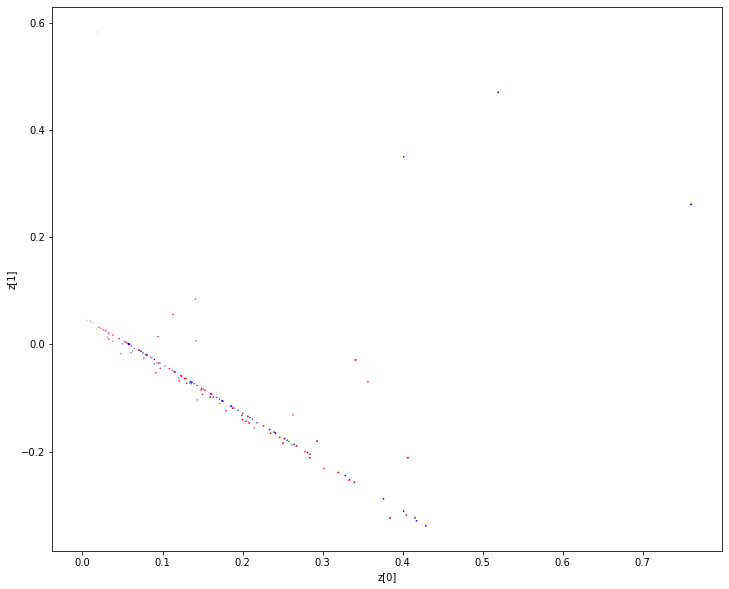

In [57]:
import matplotlib
import matplotlib.pyplot as plt
Yt_train_color=[]
#print(len(Y_train_color))
#print(Y_train_color[0])
for i in range(len(Yt_train)):
    if Yt_train[i]==1:
        Yt_train_color.append("red")
    elif Yt_train[i]==0:
        Yt_train_color.append("blue")
    else:
        Yt_train_color.append("green")
#print(Y_train_color)
z_mean = encoder.predict(Xt_train)
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 2], z_mean[:, 1] ,z_mean[:, 2], c=Yt_train_color)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.zlabel("z[2]")
plt.show()


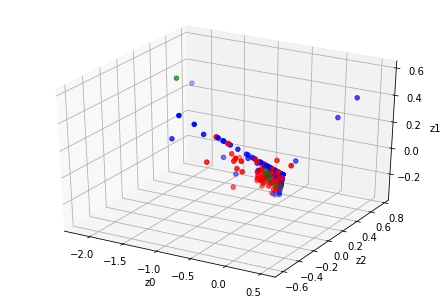

In [60]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random


fig = pyplot.figure()
ax = Axes3D(fig)

ax.scatter(z_mean[:, 0], z_mean[:, 2] ,z_mean[:, 1], c=Yt_train_color)
ax.set_xlabel('z0')
ax.set_ylabel('z2')
ax.set_zlabel('z1')
pyplot.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(history.history['squared_difference_loss'], label='Train Loss')
ax.plot(history.history['val_squared_difference_loss'], label='Validation Loss')

ax.legend()


ax.set_ylabel('loss')
ax.set_xlabel('# epochs')

plt.title('VAE Loss vs. # of Epochs')


In [61]:
names = ['jet_1_pt', ' jet_2_pt', ' A_j', ' delta_phi', ' delta_eta', ' centrality', ' frag_1', ' frag_2']
print(names)
n_examples = 300

old_x = X_train[:n_examples]
zvals = encoder.predict(old_x)
#print(zvals)
min_z = -10
max_z = 10
skip = 1

latent_vars = {}
latent_var_spectra = {}

for i in range(n_z):  
    latent_name = "z" + str(i)
    latent_vars[latent_name] = {}
    latent_var_spectra[latent_name] = np.zeros(len(names))
    layer = latent_vars[latent_name]
    for z in range(min_z, max_z, skip): 
        zvals[:, i] = z
        new_x = predictor.predict(zvals)  
        new_z = np.ones(n_examples) * z
        if "x" in layer:
            layer["x"] = np.concatenate((layer["x"], new_x))
        else:
            layer["x"] = new_x
        if "z" in layer:
            layer["z"] = np.concatenate((layer["z"], new_z), axis=0)
        else:
            layer["z"] = new_z
            
    # Take the correlation between the latent variable and all other original data variables,
    for j, real_varname in enumerate(names):
        latent_var_spectra[latent_name][j] = np.corrcoef(latent_vars[latent_name]['z'], latent_vars[latent_name]['x'][:, j])[0, 1]
        
        
        
        

['jet_1_pt', ' jet_2_pt', ' A_j', ' delta_phi', ' delta_eta', ' centrality', ' frag_1', ' frag_2']


In [62]:
latent_vars[latent_name]['z']

array([-10., -10., -10., ...,   9.,   9.,   9.])

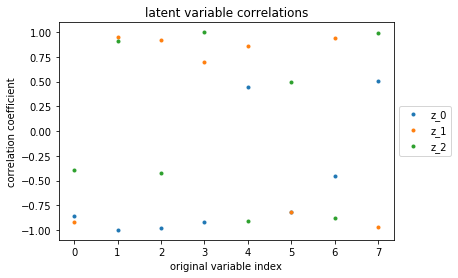

In [63]:

for i in range(n_z): 
    plt.plot(latent_var_spectra["z" + str(i)], '.', label="z_" + str(i))
plt.xlabel('original variable index')
plt.ylabel('correlation coefficient')
plt.title('latent variable correlations')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [1]:
# plot each latent variable against each real value
x_z_data = []  # {x: xvals, z: zvals, varname}
fignum = 0
for z_i in range(n_z):
    latent_varname = "z" + str(z_i)
    for j, real_varname in enumerate(names):
        fignum += 1
        title = latent_varname + "_vs_" + real_varname
        x_data = latent_vars[latent_varname]["x"][:,j]
        z_data = latent_vars[latent_varname]["z"]

        plt.scatter(z_data, x_data) 
        plt.title(title)
        plt.xlabel(latent_varname)
        plt.ylabel(real_varname)

NameError: name 'n_z' is not defined

In [5]:
!pip install --user smt

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Processing /global/u2/s/stuti/.cache/pip/wheels/11/6e/05/1ae20ee2a988d46c6812134a8e392f2c11d3e5f48396826e39/smt-0.5.3-cp37-cp37m-linux_x86_64.whl
Processing /global/u2/s/stuti/.cache/pip/wheels/49/91/2d/d08e80806bf7756193541f6c03c0492af288fcd6158d3d0998/pyDOE2-1.3.0-py3-none-any.whl
  Using cached numpydoc-1.1.0-py3-none-any.whl (47 kB)
  Using cached Sphinx-3.2.1-py3-none-any.whl (2.9 MB)
  Using cached sphinxcontrib_qthelp-1.0.3-py2.py3-none-any.whl (90 kB)
  Using cached sphinxcontrib_htmlhelp-1.0.3-py2.py3-none-any.whl (96 kB)
  Using cached sphinxcontrib_serializinghtml-1.1.4-py2.py3-none-any.whl (89 kB)
  Using cached imagesize-1.2.0-py2.py3-none-any.whl (4.8 kB)
  Using cached sphinxcontrib_applehelp-1.0.2-py2.py3-none-any.whl (121 kB)
  Using cached snowballstemmer-2.0.0-py2.py3-none-any.whl (97 

In [6]:
from __future__ import print_function, division
import numpy as np
from scipy import linalg
from smt.utils import compute_rms_error

from smt.problems import Sphere, NdimRobotArm, Rosenbrock
from smt.sampling_methods import LHS
from smt.surrogate_models import LS, QP, KPLS, KRG, KPLSK, GEKPLS
try:
    from smt.surrogate_models import IDW, RBF, RMTC, RMTB
    compiled_available = True
except:
    compiled_available = False

try:
    import matplotlib.pyplot as plt
    plot_status = True
except:
    plot_status = False

import scipy.interpolate

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

In [7]:
ndim = 2
ndoe = 20 #int(10*ndim)
# Define the function
fun = Rosenbrock(ndim=ndim)

# Construction of the DOE
sampling = LHS(xlimits=fun.xlimits, criterion='m')
xt = sampling(ndoe)
# Compute the outputs
yt = fun(xt)

# Construction of the validation points
ntest = 200 #500
sampling = LHS(xlimits=fun.xlimits)
xtest = sampling(ntest)
ytest = fun(xtest)

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 20
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.2263954
Kriging,  err: 0.0022593696068456057


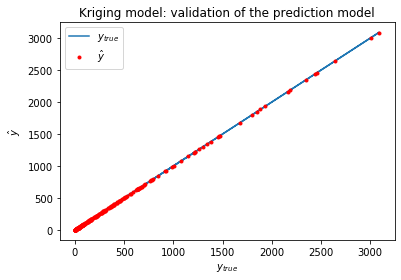

theta values [0.0528974  0.00075577]


In [8]:
########### The Kriging model

# The variable 'theta0' is a list of length ndim.
t = KRG(theta0=[1e-2]*ndim,print_prediction = False)
t.set_training_values(xt,yt[:,0])

t.train()

# Prediction of the validation points
y = t.predict_values(xtest)
print('Kriging,  err: '+ str(compute_rms_error(t,xtest,ytest)))
if plot_status:
    
# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
    fig = plt.figure()
    plt.plot(ytest, ytest, '-', label='$y_{true}$')
    plt.plot(ytest, y, 'r.', label='$\hat{y}$')
   
    plt.xlabel('$y_{true}$')
    plt.ylabel('$\hat{y}$')
    
    plt.legend(loc='upper left')
    plt.title('Kriging model: validation of the prediction model')   

if plot_status:
    plt.show()

# Value of theta
print("theta values",  t.optimal_theta)

In [62]:
names = ['jet_1_pt', ' jet_2_pt', ' A_j', ' delta_phi', ' delta_eta', ' centrality', ' frag_1', ' frag_2']

n_examples = 40

old_x = X_train[:n_examples]
zvals = encoder.predict(old_x)
xt=[]
yt=[]
for i in range(n_examples-1):
    xt.append(old_x[i+1][5])
print(xt)
for i in range(n_examples-1):
    yt.append(zvals[i+1][1])
print(yt)

[1.99, 1.99, 0.575, 0.595, 0.615, 0.695, 0.395, 0.665, 1.99, 1.99, 1.99, 0.675, 1.99, 1.99, 0.525, 1.99, 1.99, 0.585, 1.99, 1.99, 1.99, 1.99, 0.755, 0.645, 1.99, 0.525, 0.605, 1.99, 1.99, 1.99, 0.455, 1.99, 1.99, 1.99, 0.785, 1.99, 1.99, 1.99, 0.755]
[-1.0289284, -0.73042697, -0.24035385, -0.14107305, -0.090675645, -0.25935537, -0.24304527, 0.06105084, -0.4751343, -0.73494244, -0.5786384, -0.22071838, -0.70282644, -0.31621456, 0.044820417, -0.40562075, -1.0986265, -0.20891112, -0.64867353, -0.5469317, -0.7086341, -0.93509424, 0.25648385, 0.11691376, -0.29088748, -0.35758498, -0.119761266, -0.36449668, -0.2151888, -0.27235198, -0.16538894, -1.3873656, -0.62599295, -0.18625787, -0.16646546, -0.3492927, -0.64245856, -0.47172445, 0.11373679]


In [63]:

xt = np.array(xt)
yt = np.array(yt)

sm = KRG(theta0=[1e-2])
sm.set_training_values(xt, yt)
sm.train()

num = 10
x = np.linspace(-0.75, 0.75, num)
y = sm.predict_values(x)

plt.plot(xt, yt, "o")
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.legend(["Training data", "Prediction"])
plt.show()

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 39
   
___________________________________________________________________________
   
 Training
   
   Training ...


Exception: Multiple input features cannot have the same value.

In [16]:
def creator(a):
    return a*2

In [25]:
def example():
    x= np.array([1, 1.2, 1.3])
    y = creator(x) 
    print(y)
    a = tensorflow.Variable(x)
    b = creator(a)

    return tensorflow.gradients(a , b)
example()

[2.  2.4 2.6]


[None]

In [26]:
a = tensorflow.Variable(np.array([1, 1.2, 1.3]), dtype = tensorflow.float32)
b = tensorflow.Variable(np.array([1.5,0.99, 2.3]), dtype = tensorflow.float32)
g= tensorflow.gradients(a , b)

init = tensorflow.global_variables_initializer() 
init_local = tensorflow.local_variables_initializer()
with tensorflow.Session() as sess:
    sess.run([init, init_local])
    print(sess.run([g]))

TypeError: Fetch argument None has invalid type <class 'NoneType'>

In [100]:
    
intermediate_dim = 6
latent_dim = 2
       
original_dim = X_train.shape[1]

inputs = Input(shape=(original_dim,))
hidden = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, activation='linear')(hidden)
z_sigma = Dense(latent_dim,activation='linear')(hidden)
    
def sample_z(args):
    z_mean, z_sigma = args
    eps = K.random_normal(shape=(K.shape(inputs)[0],latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_sigma / 2) * eps 

z = Lambda(sample_z, output_shape=(latent_dim,))([z_mean, z_sigma])
encoder = Model(inputs, z_mean)
encoder.load_weights("testencoder_newvariables.h5")

In [101]:
n_examples = 4

old_x = X_train[:n_examples]
zvals = encoder.predict(old_x)
print(old_x.dtype)
print(zvals[:, 0])
"""
xt=[]
yt=[]
for i in range(n_examples-1):
    xt.append(old_x[i+1][5])
print(xt)
for i in range(n_examples-1):
    yt.append(zvals[i+1][1])
print(yt)
"""

float64
[ 0.30303162 -0.07653354 -0.16930026 -0.34457913]


'\nxt=[]\nyt=[]\nfor i in range(n_examples-1):\n    xt.append(old_x[i+1][5])\nprint(xt)\nfor i in range(n_examples-1):\n    yt.append(zvals[i+1][1])\nprint(yt)\n'

In [97]:

x = tensorflow.placeholder(tensorflow.float64, shape=[None, 9])
print(x)
y =  encoder.predict(x, steps=1)
print(y.shape)
var_grad = tensorflow.gradients(y, x)
input_x=old_x
print(input_x.dtype)
with tensorflow.Session() as session:
    var_grad_val = session.run(var_grad,feed_dict={x:input_x}) 

print(var_grad_val)

Tensor("Placeholder_40:0", dtype=float64)


ValueError: Cannot take the length of shape with unknown rank.

In [91]:
print(np.array([1, 2, 3]))

[1 2 3]


In [106]:
output_v = model.output
input_v = model.input
gradients = tensorflow.gradients(output_v, input_v)

#sess = tensorflow.Session()
#sess.run(tensorflow.initialize_all_variables())

with tensorflow.Session() as sess:
    evaluated_gradients = sess.run(gradients,feed_dict{model.input:old_x})

#print(sess.run(encoder.input,feed_dict={model.input:old_x}))

print(evaluated_gradients)

sess.close()

SyntaxError: invalid syntax (<ipython-input-106-aa4a677e6164>, line 9)

In [108]:
input = old_x
image = tensorflow.Variable(input)

with tensorflow.GradientTape() as tape:
    tape.watch(image)
    prediction = encoder.predict(image)
        
grads = tape.gradient(prediction, image)
print(grads)


SystemError: <built-in function TFE_Py_TapeWatch> returned a result with an error set